In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [30]:
#reading the csv file
dir  = globals()['_dh'][0].parent
file_path = dir / 'data' / 'cleaned_data.pkl'
df = pd.read_pickle(file_path)
print(df.shape)
df.head(5)


(16680, 16)


,OrgID,EnrollDate,ChurnDate,OrgSize,Industry,IndustryGroup,Enrollment Plan,PromoType,Acquisition Channel,F28 Active Rate,Avg Lifetime Active,F28 Cc Flag,eLTV/CAC,Churned,Enrollment Duration,User_id
0,44,2021-02-01,NaT,0-1,Flooring,Other,Extra large,No Promo,Marketing - Paid,0.607,0.096,0,4.1,0,676.0,4420210201
1,70,2022-03-01,NaT,0-1,Plumbing,Plumbing,Starter,No Promo,NaN,0.071,0.340,0,1.2,0,283.0,7020220301
2,1494,2020-10-02,NaT,0-1,Carpet Cleaning,Carpet Cleaning,Small,No Promo,Product,1.000,0.379,1,3.4,0,798.0,149420201002
3,1604,2020-10-08,2020-12-08,11+,Restoration,Other,Large,2+ month,Sales,0.500,0.004,0,6.2,1,61.0,160420201008
4,1652,2020-02-03,2020-03-02,11+,Solar & Energy,Other,Large,One Month,Sales,0.000,0.001,0,4.7,1,28.0,165220200203


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16680 entries, 0 to 16679
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   OrgID                16680 non-null  int64         
 1   EnrollDate           16680 non-null  datetime64[ns]
 2   ChurnDate            6703 non-null   datetime64[ns]
 3   OrgSize              16671 non-null  category      
 4   Industry             16655 non-null  object        
 5   IndustryGroup        16680 non-null  object        
 6   Enrollment Plan      16677 non-null  category      
 7   PromoType            16680 non-null  category      
 8   Acquisition Channel  15947 non-null  object        
 9   F28 Active Rate      16680 non-null  float64       
 10  Avg Lifetime Active  16680 non-null  float64       
 11  F28 Cc Flag          16680 non-null  int64         
 12  eLTV/CAC             16549 non-null  float64       
 13  Churned              16680 non-

In [32]:
#preparing the data for kmeans
df.drop(['EnrollDate', 'ChurnDate', 'IndustryGroup', 'User_id', 'OrgID'], axis=1, inplace=True)
df = df.dropna()
df = df.reset_index(drop=True)

#getting dummies for categorical
df = pd.concat([df, pd.get_dummies(df['Industry'], prefix='Industry')], axis=1)
df = pd.concat([df, pd.get_dummies(df['Acquisition Channel'], prefix='Channel')], axis=1)
df.drop(['Industry','Acquisition Channel'], axis=1, inplace=True)

#ordinal encoding categorical variables
replace_org = {'0-1' : 1, 
                '2-6' : 2, 
                '7-10' : 3, 
                '11+': 4}
df.replace({'OrgSize' : replace_org}, inplace=True)

replace_enr = {'Starter' : 1, 
                'Small' : 2, 
                'Medium' : 3, 
                'Large': 4,
                'Extra large' : 5}
df.replace({'Enrollment Plan' : replace_enr}, inplace=True)

replace_promo = {'No Promo' : 1, 
                'One Month' : 2, 
                'Special - One Month' : 3, 
                '2+ month': 4}
df.replace({'PromoType' : replace_promo}, inplace=True)


print(df.shape)
df.head(5)

df.to_pickle(dir / 'data' / 'prepared_kmeans_data.pkl')


(15797, 112)


In [33]:
df['OrgSize'].unique()

[1, 4, 2, 3]
Categories (4, int64): [1 < 2 < 3 < 4]

In [34]:
# 1. Data Preparation
# Separate churned customers
churned_customers = df[df['Churned'] == 1].copy()
print(f"Total customers: {len(df)}")
print(f"Churned customers: {len(churned_customers)} ({len(churned_customers)/len(df)*100:.2f}%)")

Total customers: 15797
Churned customers: 6390 (40.45%)


In [35]:
X = churned_customers.drop('Churned', axis=1)

features = list(X.columns)

In [36]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [37]:
# 4. Determining optimal number of clusters using Elbow Method
inertia = []
silhouette_scores = []
k_range = range(2, 30)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

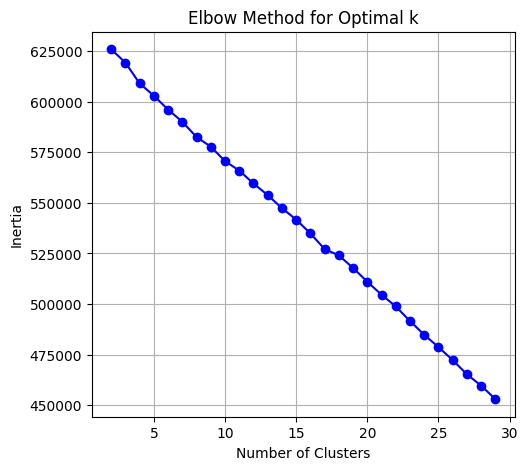

In [38]:
# Plot Elbow Method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

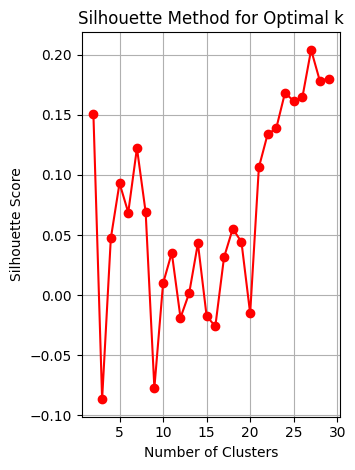

In [39]:
# Plot Silhouette Method
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.grid(True)
plt.tight_layout()
plt.savefig('optimal_clusters.png')
plt.show()

In [40]:
# 5. Apply K-means clustering with the optimal number of clusters
# Choose the optimal k based on the plots (modify this value)
optimal_k = 2  # Example: set this to your chosen optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
churned_customers['Cluster'] = kmeans.fit_predict(X_scaled)

In [41]:
# 6. Analyze cluster characteristics
print("\nCluster Sizes:")
print(churned_customers['Cluster'].value_counts())

print("\nCluster Characteristics:")
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                               columns=features)
print(cluster_centers)


Cluster Sizes:
Cluster
0    5459
1     931
Name: count, dtype: int64

Cluster Characteristics:
    OrgSize  Enrollment Plan  PromoType  F28 Active Rate  Avg Lifetime Active  \
0  1.536728         1.824144   1.856384         0.121942             0.044210   
1  2.285714         4.213749   2.953813         0.181807             0.073369   

   F28 Cc Flag  eLTV/CAC  Enrollment Duration  Industry_Accountant  \
0     0.096904  1.859333            79.060084             0.000183   
1     0.109560  8.809452            80.756176             0.001074   

   Industry_Air Duct Cleaning  ...  Industry_Wildlife Control  \
0                5.678696e-03  ...               1.831837e-04   
1               -5.204170e-18  ...              -1.897354e-19   

   Industry_Window & Exterior Cleaning  Industry_Windows  Channel_BD  \
0                             0.050559      1.648654e-03    0.012823   
1                             0.038668     -1.951564e-18    0.073040   

   Channel_Innovation  Channel_Marke

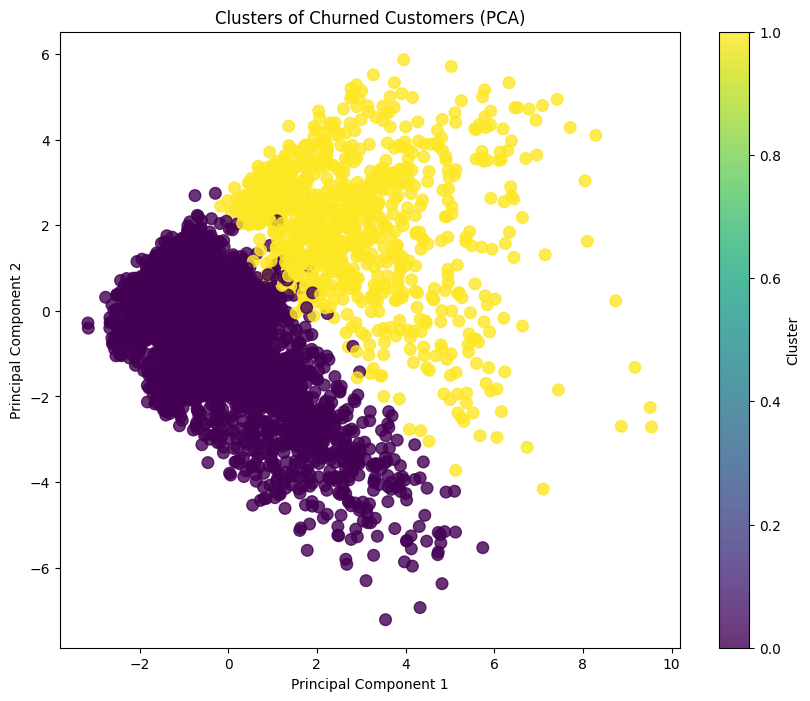

In [42]:
# 7. Visualize clusters with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=churned_customers['Cluster'], 
            cmap='viridis', alpha=0.8, s=70)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters of Churned Customers (PCA)')
plt.colorbar(label='Cluster')
plt.savefig('cluster_pca.png')
plt.show()

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

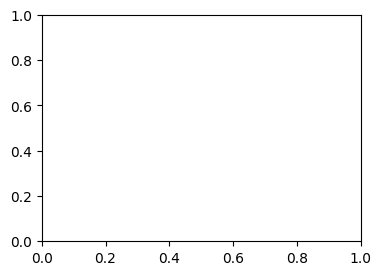

In [43]:
# 8. Feature importance per cluster
plt.figure(figsize=(14, 10))

for feature_idx, feature in enumerate(features):
    plt.subplot(3, 3, feature_idx + 1)
    for cluster_idx in range(optimal_k):
        cluster_data = churned_customers[churned_customers['Cluster'] == cluster_idx]
        sns.kdeplot(cluster_data[feature], label=f'Cluster {cluster_idx}')
    
    plt.title(feature)
    plt.legend()

plt.tight_layout()
plt.savefig('feature_distribution.png')
plt.show()

In [ ]:
# 9. Create a comprehensive cluster profile
print("\nDetailed Cluster Profiles:")
cluster_profiles = churned_customers.groupby('Cluster')[features].mean()
print(cluster_profiles)


Detailed Cluster Profiles:
                 OrgID  F28 Active Rate  Avg Lifetime Active  F28 Cc Flag  \
Cluster                                                                     
0        358459.762136         0.126183             0.052093     0.100000   
1        341038.537393         0.179997             0.071905     0.111111   
2        358625.669100         0.189481             0.071504     0.171776   
3        333386.668214         0.062099             0.017623     0.029970   

         eLTV/CAC  Enrollment Duration  OrgSize_0-1  OrgSize_2-6  \
Cluster                                                            
0        0.875728            72.795146     0.754369     0.222330   
1        8.842949            79.693376     0.250000     0.398504   
2        2.285304            84.911436     0.596107     0.380535   
3        1.889574            77.124525     0.317856     0.634023   

         OrgSize_7-10  OrgSize_11+  ...  Promo_One Month  \
Cluster                             ... 

In [ ]:
# Calculate the standard deviation for each feature in each cluster
cluster_std = churned_customers.groupby('Cluster')[features].std()

In [ ]:
# 10. Generate cluster descriptions and insights
print("\nCluster Insights:")
for cluster_idx in range(optimal_k):
    print(f"\nCluster {cluster_idx} ({len(churned_customers[churned_customers['Cluster'] == cluster_idx])} customers):")
    
    # Get the top 3 distinguishing features for this cluster
    cluster_profile = cluster_profiles.loc[cluster_idx]
    global_mean = X.mean()
    
    # Calculate how much each feature deviates from the global mean (in terms of standard deviations)
    feature_deviations = (cluster_profile - global_mean) / global_mean.std()
    
    # Get the top distinguishing features (both positive and negative deviations)
    distinguishing_features = feature_deviations.abs().sort_values(ascending=False).head(3)
    
    for feature in distinguishing_features.index:
        direction = "higher" if feature_deviations[feature] > 0 else "lower"
        print(f"- {feature}: {cluster_profile[feature]:.2f} ({direction} than average by {abs(feature_deviations[feature]):.2f} std)")


Cluster Insights:

Cluster 0 (1030 customers):
- OrgID: 358459.76 (higher than average by 0.38 std)
- Enrollment Duration: 72.80 (lower than average by 0.00 std)
- eLTV/CAC: 0.88 (lower than average by 0.00 std)

Cluster 1 (936 customers):
- OrgID: 341038.54 (lower than average by 0.18 std)
- eLTV/CAC: 8.84 (higher than average by 0.00 std)
- Plan_Small: 0.00 (lower than average by 0.00 std)

Cluster 2 (2055 customers):
- OrgID: 358625.67 (higher than average by 0.38 std)
- Enrollment Duration: 84.91 (higher than average by 0.00 std)
- eLTV/CAC: 2.29 (lower than average by 0.00 std)

Cluster 3 (2369 customers):
- OrgID: 333386.67 (lower than average by 0.42 std)
- Enrollment Duration: 77.12 (lower than average by 0.00 std)
- eLTV/CAC: 1.89 (lower than average by 0.00 std)
